2. Data Preparation

In [1]:
import os
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

In [2]:
# Load Images
DATASET_CLEAN_PATH = os.path.join("Dataset", "Dataset Clean")

images = []
classes = []
class_names = {}

for idx, label in enumerate(os.listdir(DATASET_CLEAN_PATH)):
    for filename in os.listdir(os.path.join(DATASET_CLEAN_PATH, label)):
        image_path = os.path.join(DATASET_CLEAN_PATH, label, filename)

        # Load images with no target size and further preprocessing for actual exploration to the data for the raw images (true images)
        image = load_img(image_path, color_mode="rgb", target_size=(100, 100))
            # From observation, the image size varies, so we use target size 100, 100 because we can still distinctly see the pattern
            # without compressing the image too much
        image = np.asarray(image) / 255.
        images.append(image)
        classes.append(idx)

    class_names[idx] = label
    print(f"Class {label} loaded sucessfully")

Class batik-betawi loaded sucessfully
Class batik-megamendung loaded sucessfully
Class batik-parang loaded sucessfully


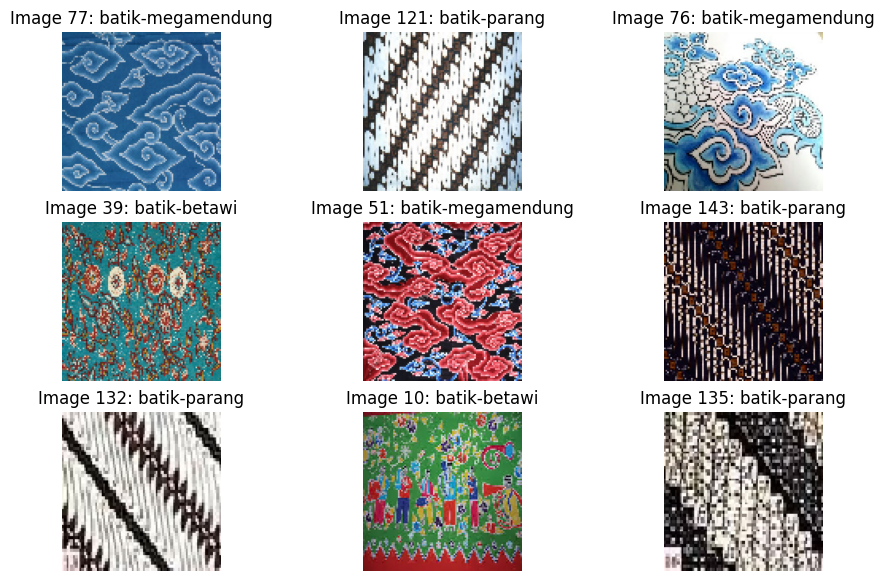

In [3]:
# Load Sample image for each classes
from matplotlib import pyplot as plt
import random

plt.figure(figsize=(11, 7))
for i in range(9):
    plt.subplot(3, 3, i+1)
    randomNum = random.randrange(0, len(images))
    plt.imshow(images[randomNum] ,cmap='gray')
    plt.axis('off')
    plt.title(f"Image {randomNum}: {class_names[classes[randomNum]]}")

plt.show()

In [4]:
from sklearn.model_selection import train_test_split

# Train Test Split
x_train, x_temp, y_train, y_temp = train_test_split(images, classes, test_size=0.2, random_state=42, shuffle=True, stratify=classes)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=True, stratify=y_temp)

print(f"Length of training data {len(y_train)}")
print(f"Length of testing data {len(y_test)}")
print(f"Length of validation data {len(y_val)}")

Length of training data 116
Length of testing data 15
Length of validation data 14


In [5]:
# Categorical Encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Convert to numpy array
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

model = Sequential([
    Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(100, 100, 3)),
    Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPool2D(pool_size=(3, 3)),
    Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    Conv2D(1048, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPool2D(pool_size=(3, 3)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(len(class_names), activation='softmax')
])

In [7]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 256)     295168    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 256)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 33, 512)       1180160   
                                                                 
 conv2d_3 (Conv2D)           (None, 33, 33, 1048)      4830232   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 1048)     0         
 2D)                                                    

In [8]:
# HYPERPARAMETERS
BATCH_SIZE = 12
EPOCHS = 100

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    horizontal_flip=True,
)

datagen.fit(x_train)
train_ds = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

steps_per_epoch = len(x_train) // BATCH_SIZE
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True) 
history = model.fit(train_ds,
                        validation_data=(x_val, y_val), 
                        epochs=EPOCHS,
                        steps_per_epoch=steps_per_epoch, 
                        callbacks=[early_stopping])

Epoch 1/100
9/9 [==============================] - 9s 409ms/step - loss: 3.6401 - accuracy: 0.2870 - val_loss: 1.0983 - val_accuracy: 0.3571
Epoch 2/100
9/9 [==============================] - 4s 217ms/step - loss: 1.0962 - accuracy: 0.3558 - val_loss: 1.0666 - val_accuracy: 0.3571
Epoch 3/100
9/9 [==============================] - 2s 198ms/step - loss: 1.0998 - accuracy: 0.4135 - val_loss: 1.0702 - val_accuracy: 0.3571
Epoch 4/100
9/9 [==============================] - 2s 209ms/step - loss: 1.0889 - accuracy: 0.3750 - val_loss: 1.0449 - val_accuracy: 0.3571
Epoch 5/100
9/9 [==============================] - 2s 216ms/step - loss: 1.0652 - accuracy: 0.4615 - val_loss: 0.9907 - val_accuracy: 0.6429
Epoch 6/100
9/9 [==============================] - 2s 216ms/step - loss: 0.9902 - accuracy: 0.6019 - val_loss: 0.9705 - val_accuracy: 0.5000
Epoch 7/100
9/9 [==============================] - 2s 210ms/step - loss: 0.9145 - accuracy: 0.5769 - val_loss: 0.9261 - val_accuracy: 0.5714
Epoch 8/100
9

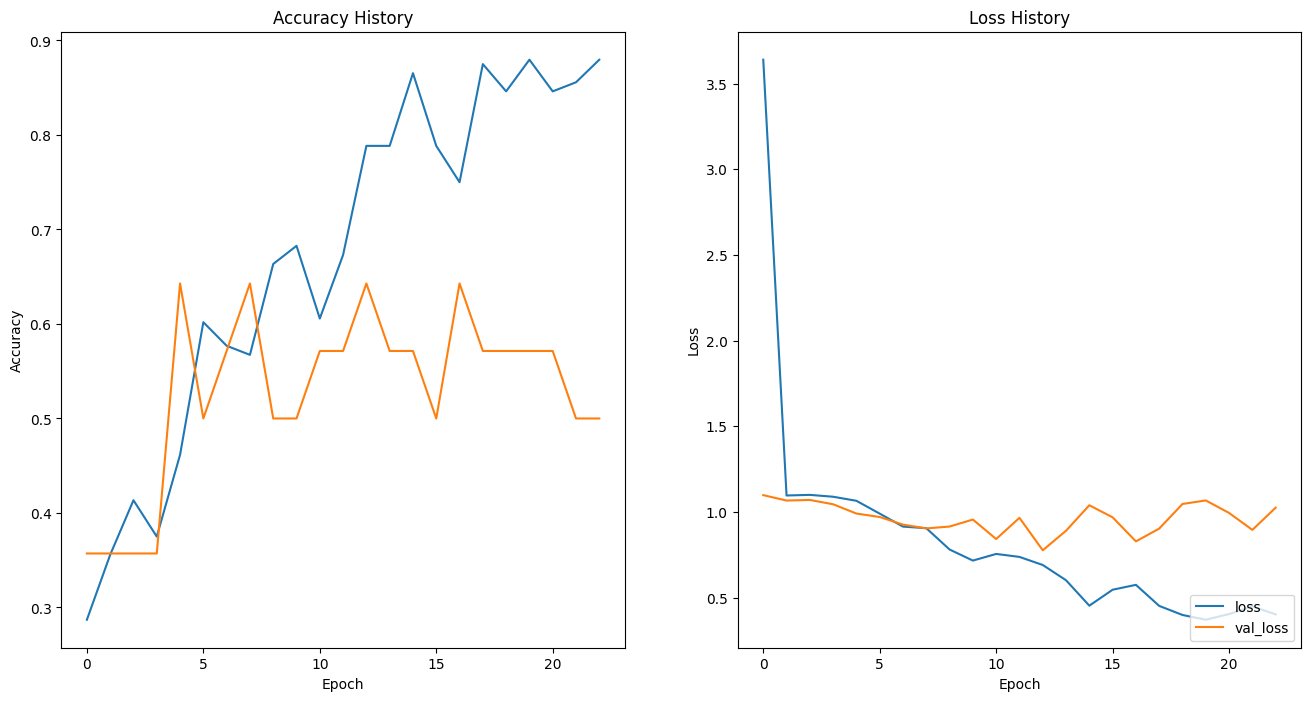

In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy History")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss History")

plt.legend(loc='lower right')
plt.show()

In [12]:
# Evaluate Model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

1/1 [==============================] - 2s 2s/step - loss: 0.5770 - accuracy: 0.7333
Loss: 0.5769683718681335
Accuracy: 0.7333333492279053


1/1 [==============================] - 0s 20ms/step


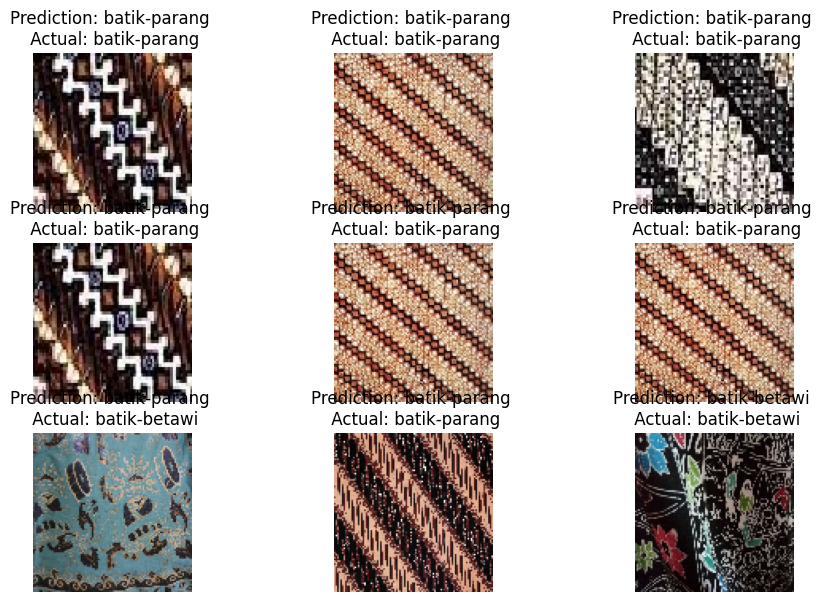

In [13]:
# Sample Prediction
import random

plt.figure(figsize=(11, 7))
for i in range(9):
    plt.subplot(3, 3, i+1)
    randomNum = random.randrange(0, len(x_test))
    prediction = model.predict(x_test[randomNum].reshape(1, 100, 100, 3))
    plt.imshow(x_test[randomNum])
    plt.axis('off')
    plt.title(f"Prediction: {class_names[np.argmax(prediction)]} \n Actual: {class_names[np.argmax(y_test[randomNum])]}")

In [14]:
# model.save("model/DCNN_Scratch.h5")